##まとめ
* WordNetなどのシソーラスを利用して、類義語の取得や単語間の類似度の計測など有用なタスクを行うことができる
* シソーラスを用いる手法には、シソーラスを作成する人の作業量や新しい単語への対応などの問題がある
* 現在ではコーパスを利用して単語をベクトル化するアプローチが主流である
* 近年の単語ベクトル化の手法では、「単語の意味は、周囲の単語によって形成される」という分布仮説に基づくものがほとんどである
* カウントベースの手法は、コーパス中の各単語に対して、その単語の周囲の単語の頻度をカウントし集計する（＝共起行列）
* 共起行列をPPMI行列に変換し、それを次元削減することで、巨大な「疎なベクトル」を小さな「密なベクトル」へと変換することができる
* 単語のベクトル空間では、意味的に近い単語はその距離が近くなることが期待される

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


##カウントベースの手法

###Pythonによるコーパスの下準備
* コーパス:文を単語IDに置き換えたリスト

In [3]:
def preprocess(text):
    text=text.lower()   #すべて小文字に変換する
    text=text.replace('.',' .') #'.'の前にスペースを挿入する
    words=text.split(' ')   #文をスペースで区切ってリストに格納する

    word_to_id={}   #｛単語:ID｝
    id_to_word={}   #{ID:単語}

    for word in words:
        if word not in word_to_id:
            id=len(id_to_word)  #単語に順にIDを振っていく
            word_to_id[word]=id
            id_to_word[id]=word

    corpus=np.array([word_to_id[w] for w in words]) #文をコーパス（単語IDに置き換えたリスト）に変換

    return corpus,word_to_id,id_to_word 

In [4]:
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


###共起行列
文中で注目している単語の周辺にある単語の数をカウントした行列  

行方向が注目している単語、列方向がその他の単語が注目している単語の周辺に出現した回数

In [5]:
def create_co_matrix(corpus,vocab_size,window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vocab_size,vocab_size),dtype=np.int32)

    for idx,word_id in enumerate(corpus):   #idx:注目している単語のidx(文中の場所) , word_id:注目している単語のID
        for i in range(1,window_size+1):
            left_idx=idx-i  #注目している単語の左側の単語の文中の場所
            right_idx=idx+i

            if left_idx>=0:
                left_word_id=corpus[left_idx]   #左側の単語のIDを取得
                co_matrix[word_id,left_word_id]+=1  #注目している単語と左側に出現した単語の共起カウントを＋１

            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id,right_word_id]+=1

    return co_matrix

In [6]:
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
C=create_co_matrix(corpus,7,1)
print(C)

N=np.sum(C)
print(N)

S=np.sum(C,axis=0)
print(S)

total=C.shape[0]*C.shape[1]
print(total)
print(S/N)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
14
[1 4 2 2 2 2 1]
49
[0.07142857 0.28571429 0.14285714 0.14285714 0.14285714 0.14285714
 0.07142857]


###ベクトル間の類似度

In [7]:
#コサイン類似度
def cos_similarity(x,y,eps=1e-8):  #eps:イプシロン,ゼロ除算対策の小さい値
    nx=x/(np.sqrt(np.sum(x**2))+eps)  #xの正規化(L2ノルムで割る)
    ny=y/(np.sqrt(np.sum(y**2))+eps)  #yの正規化(L2ノルムで割る)
    return np.dot(nx,ny)    #ベクトルの内積を取る

In [17]:
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)

c0=C[word_to_id['you']]
c1=C[word_to_id['i']]

print(cos_similarity(c0,c1))

0.7071067691154799


###類似単語のランキング表示

In [18]:
def most_similar(query,word_to_id,id_to_word,word_matrix,top=5):
    if query not in word_to_id: #queryがword_to_idに含まれていない場合
        print('%s is not found.'%query)
        return

    print('\n[query]'+query)
    query_id=word_to_id[query]  #queryのidを取得
    query_vec=word_matrix[query_id] #queryのベクトルを取得

    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)

    for i in range(vocab_size):   #すべての単語とのコサイン類似度を計算してsimilarityに格納
        similarity[i]=cos_similarity(word_matrix[i],query_vec)

    # print((-1*similarity).argsort())
    count=0
    for i in (-1*similarity).argsort(): #値が高い順にソートしたインデックスを返す
        if id_to_word[i]==query:
            continue
        print('%s: %s'%(id_to_word[i],similarity[i]))

        count+=1
        if count>=top:
            return

In [19]:
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)

most_similar('goodbye',word_to_id,id_to_word,C,top=3)


[query]goodbye
i: 0.9999999858578643
you: 0.7071067691154799
hello: 0.49999999292893216


###カウントベースの手法の改善
* PMI（Pointwise Mutual Information : 相互情報量）  
共起行列では周辺語の出現回数をカウントしただけなので、高頻度語（theなど）の関連性が高くなってしまう.
PMIでは、単語単独の出現回数を考慮することで、高頻度語の影響を低減する.  

$$
\mathrm {PMI}(x,y) = log_2 \dfrac{P(x,y)}{P(x)P(y)}= log_2 \dfrac{\dfrac{C(x,y)}{N}}{\dfrac{C(x)}{N}\dfrac{C(y)}{N}}=log_2 \dfrac{C(x,y)\cdot N}{C(x)C(y)}\\
C(x,y) : xとyの共起回数\\C(x):xの出現回数\\C(y):yの出現回数\\N:文中の全単語数
$$
* PPMI（Positive PMI : 正の相互情報量）  
PMIでは２つの単語の共起する回数が０の場合、$$log_20=-\infty$$となってしまうため、実践上ではPPMIが用いられる  

$$
\mathrm {PPMI}(x,y)=\mathrm{max}(0,\mathrm{PMI}(x,y))
$$

In [20]:
def ppmi(C,verbose=True,eps=1e-8):
    M=np.zeros_like(C,dtype=np.float32)
    N=np.sum(C) #共起行列のすべての共起回数の合計
    S=np.sum(C,axis=0)  #各単語ごとの共起回数の合計
    total=C.shape[0]*C.shape[1] #共起行列の全要素数
    cnt=0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i,j]*N/(S[i]*S[j]+eps))   #PMIを計算（）
            ppmi=max(0,pmi)
            M[i,j]=ppmi
            
            if verbose:
                cnt+=1
                if cnt%(total//100+1)==0:
                    print('%.1f%%done'%(100*cnt/total))

    return M

In [21]:
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)

W=ppmi(C)
np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

2.0%done
4.1%done
6.1%done
8.2%done
10.2%done
12.2%done
14.3%done
16.3%done
18.4%done
20.4%done
22.4%done
24.5%done
26.5%done
28.6%done
30.6%done
32.7%done
34.7%done
36.7%done
38.8%done
40.8%done
42.9%done
44.9%done
46.9%done
49.0%done
51.0%done
53.1%done
55.1%done
57.1%done
59.2%done
61.2%done
63.3%done
65.3%done
67.3%done
69.4%done
71.4%done
73.5%done
75.5%done
77.6%done
79.6%done
81.6%done
83.7%done
85.7%done
87.8%done
89.8%done
91.8%done
93.9%done
95.9%done
98.0%done
100.0%done
covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


###SVDによる次元削減
共起行列またはPPMIは疎な行列（殆どの要素が０）なため、SVD(Singular Value Decomposition:特異値分解)により密な行列に圧縮する  

$$
\begin{eqnarray}
\mathrm X&=&\mathrm U\mathrm S \mathrm V^\mathrm T\\
U &:& 直交行列\\S&:&対角行列(特異値(対応する軸の影響度)が降順で並んでいる)\\V&:&直交行列\\
\end{eqnarray}
$$

In [22]:
#SVDによる次元削減
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)
W=ppmi(C)

U,S,V=np.linalg.svd(W)

print(C)
print(W[0])
print(U[0])

2.0%done
4.1%done
6.1%done
8.2%done
10.2%done
12.2%done
14.3%done
16.3%done
18.4%done
20.4%done
22.4%done
24.5%done
26.5%done
28.6%done
30.6%done
32.7%done
34.7%done
36.7%done
38.8%done
40.8%done
42.9%done
44.9%done
46.9%done
49.0%done
51.0%done
53.1%done
55.1%done
57.1%done
59.2%done
61.2%done
63.3%done
65.3%done
67.3%done
69.4%done
71.4%done
73.5%done
75.5%done
77.6%done
79.6%done
81.6%done
83.7%done
85.7%done
87.8%done
89.8%done
91.8%done
93.9%done
95.9%done
98.0%done
100.0%done
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


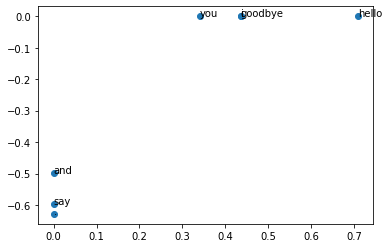

In [23]:
#次元削減した上で各単語を２次元のベクトルで表し、グラフ化
for word,word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0],U[word_id,1]))  #2次元化するには単純に先頭の２つの要素を取り出す
plt.scatter(U[:,0],U[:,1])
plt.show()

###PTBデータセット
PTB（Penn Treebank）: word2vecの発明者であるTomas Mikolovによって公開されているコーパス(テキストファイル)

In [24]:
from dataset import ptb

corpus,word_to_id,id_to_word=ptb.load_data('train')

print('corpus size:',len(corpus))
print('corpus[:30]',corpus[:30])
print()
print('id_to_word[0]:',id_to_word[0])
print('id_to_word[1]:',id_to_word[1])

print("word_to_id['car']:",word_to_id['car'])
print("word_to_id['happy']:",word_to_id['happy'])

corpus size: 929589
corpus[:30] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
word_to_id['car']: 3856
word_to_id['happy']: 4428


###PTBデータセットでの評価

In [25]:
from dataset import ptb

window_size=2
wordvec_size=100    #次元削減後の次元数

corpus,word_to_id,id_to_word=ptb.load_data('train') #データセットの読み込み
vocab_size=len(word_to_id)  #語彙数
print('counting co-occurence ...')
C=create_co_matrix(corpus,vocab_size,window_size)   #共起行列の生成
print('calculating PPMI ...')
W=ppmi(C,verbose=True)  #共起行列をPPMI行列へ変換
print('calculating SVD ...')
try:
    from sklearn.utils.extmath import randomized_svd    #svdによる次元削減
    U,S,V=randomized_svd(W,n_components=wordvec_size,n_iter=5,random_state=None)
except ImportError:
    U,S,V=np.linalg.svd(W)

word_vecs=U[:,:wordvec_size]    #次元削減後の行列

querys=['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)

counting co-occurence ...
calculating PPMI ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


1.0%done
2.0%done
3.0%done
4.0%done
5.0%done
6.0%done
7.0%done
8.0%done
9.0%done
10.0%done
11.0%done
12.0%done
13.0%done
14.0%done
15.0%done
16.0%done
17.0%done
18.0%done
19.0%done
20.0%done
21.0%done
22.0%done
23.0%done
24.0%done
25.0%done
26.0%done
27.0%done
28.0%done
29.0%done
30.0%done
31.0%done
32.0%done
33.0%done
34.0%done
35.0%done
36.0%done
37.0%done
38.0%done
39.0%done
40.0%done
41.0%done
42.0%done
43.0%done
44.0%done
45.0%done
46.0%done
47.0%done
48.0%done
49.0%done
50.0%done
51.0%done
52.0%done
53.0%done
54.0%done
55.0%done
56.0%done
57.0%done
58.0%done
59.0%done
60.0%done
61.0%done
62.0%done
63.0%done
64.0%done
65.0%done
66.0%done
67.0%done
68.0%done
69.0%done
70.0%done
71.0%done
72.0%done
73.0%done
74.0%done
75.0%done
76.0%done
77.0%done
78.0%done
79.0%done
80.0%done
81.0%done
82.0%done
83.0%done
84.0%done
85.0%done
86.0%done
87.0%done
88.0%done
89.0%done
90.0%done
91.0%done
92.0%done
93.0%done
94.0%done
95.0%done
96.0%done
97.0%done
98.0%done
99.0%done
calculating SVD ...